In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


GPU_ID = 2
if torch.cuda.is_available():
    # torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2

5 GPU(s) available:
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090


In [2]:
undisp_cube, mask, spectras = hlp.create_bs_data(desired_channels=21,interp_type='average') #here we'll work with synthetic data. 

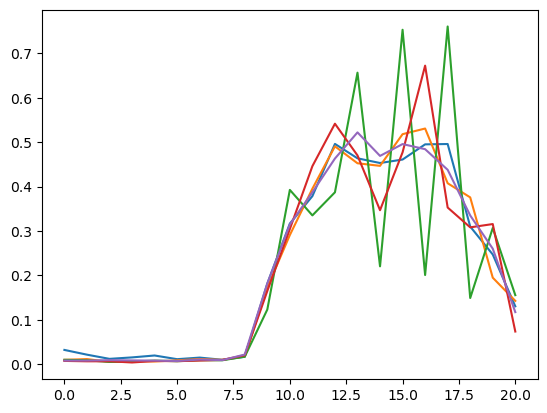

In [3]:
for i in range(0,2900,600):
    plt.plot(spectras[:,i].cpu().numpy(),label=str(i))

In [4]:
batch_size = 2
torch.cuda.empty_cache()


kernel = create_fourier_kernel().unsqueeze(0).permute(0,3,1,2).to('cuda')

dataset = hlp.SyntheticDataset(undispersed_cube=undisp_cube,shift_info={'kernel':kernel}, spectra = spectras)

allindexes = np.arange(len(dataset))
np.random.shuffle(allindexes)
tr_indexes = allindexes[:int(0.05*len(allindexes))]#np.array([[2281]])
v_indexes = allindexes[int(0.05*len(allindexes)):int(0.06*len(allindexes))] #np.array([[1135]])

# Create a data loader for batch processing
tr_loader = hlp.CustomDataLoader(dataset, tr_indexes, batch_size=batch_size, shuffle=True)
v_loader = hlp.CustomDataLoader(dataset, v_indexes, batch_size=batch_size, shuffle=True)


In [ ]:

model = fourier_denoiser(mask=mask, kernel=kernel).to('cuda')

lr = 5e-4
epochs = 15


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.MSELoss()


history = hlp.train(model, optimizer, loss, tr_loader, v_loader, epochs=epochs, device='cuda')

torch.cuda.empty_cache()

# torch.save(model.state_dict(), 'fourier_denoiser')

# plt.plot(np.log10(history['loss']),'r',label = 'train')
# plt.plot(np.log10(history['val_loss']),'k', label = 'val')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('log10(MSE)')

## Test a model I trained on all the data (using train_model.py)

In [7]:
model = fourier_denoiser(mask=mask, kernel=kernel).to('cuda')
model.load_state_dict(torch.load('fourier_denoiser_b')); #trained on all data.
model.eval();

In [9]:
# %%timeit

indexes = [600,1800]
(x,y) = dataset[indexes]
# y = (undisp_cube>0.1) * spectras[:,1200].unsqueeze(-1).unsqueeze(-1).unsqueeze(0) #*STC.unsqueeze(0)
# x = fwd.calc_psi_z(torch.ones_like(y),y,{'kernel':kernel})
# y = model.crop(y)

y_pred = model(x)

Text(0.5, 1.0, 'Original')

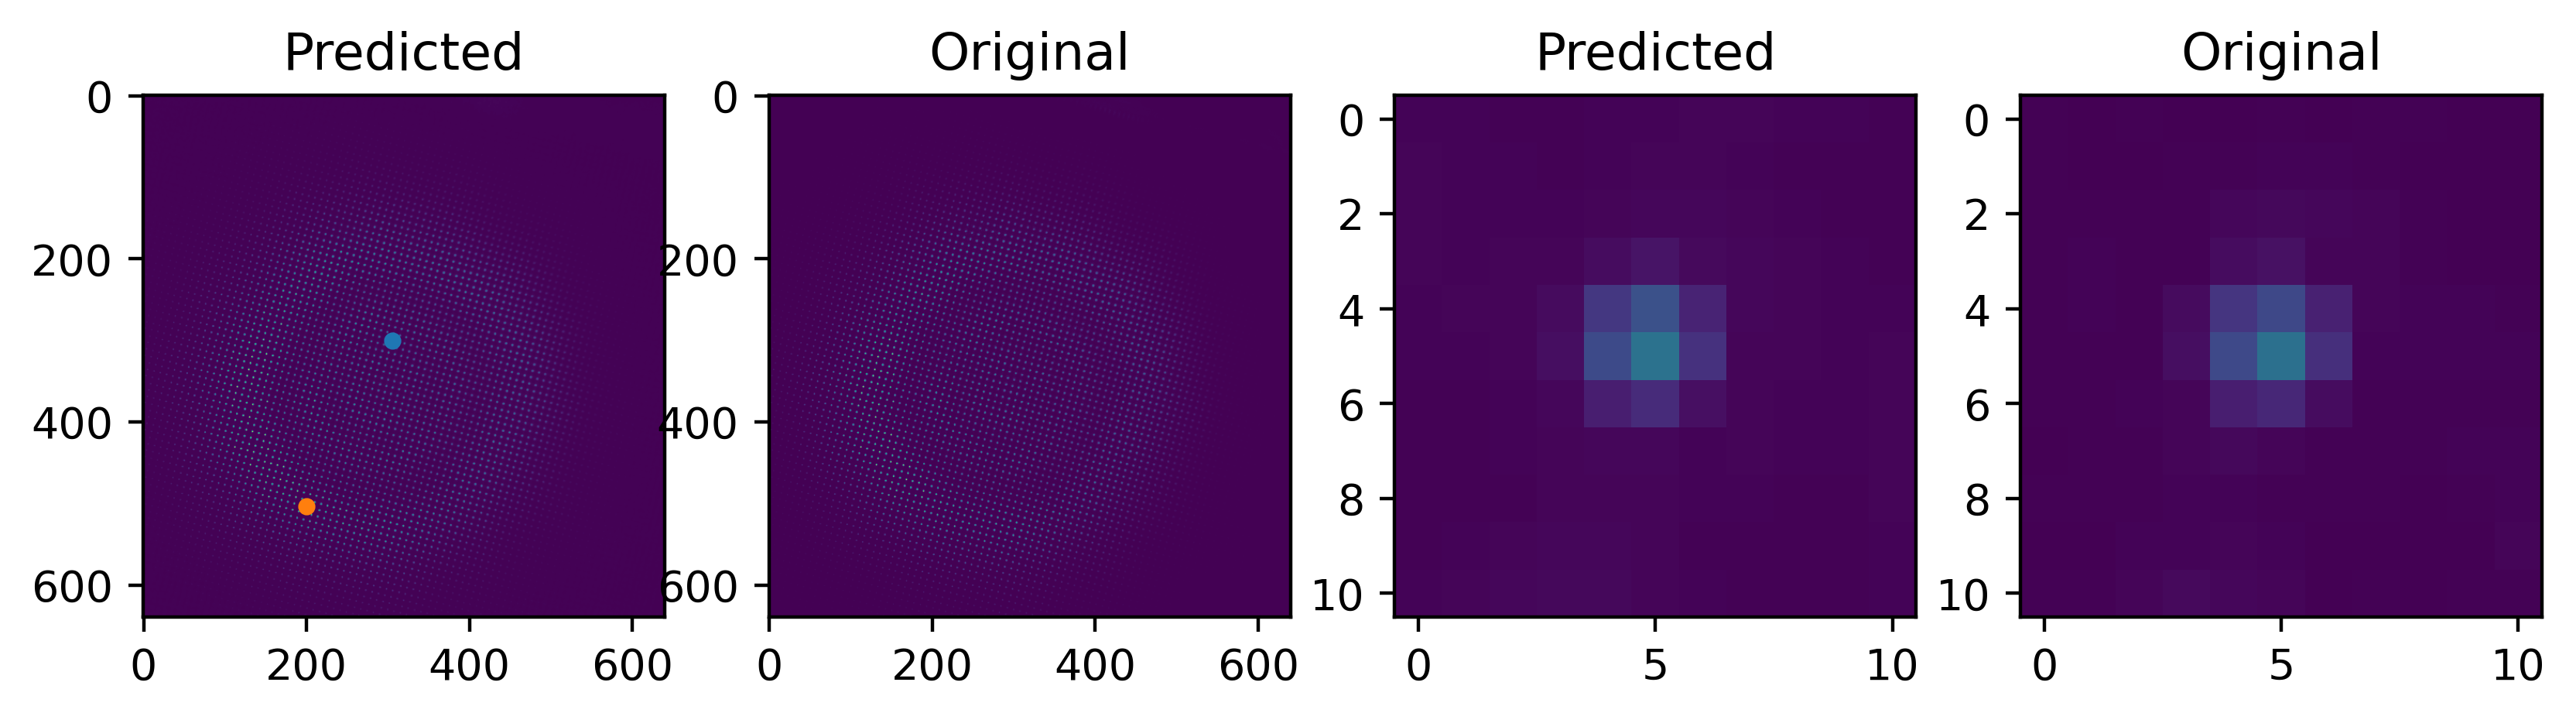

In [10]:
fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[0,10].cpu().detach().numpy()); ax[0].set_title('Predicted')
ax[1].imshow(y[0,10].cpu().detach().numpy())    ; ax[1].set_title('Original')

coords1 = [300,305]
boxsize = 5

coords2 = [504,200]

ax[0].plot(coords1[1],coords1[0],'.')

ax[0].plot(coords2[1],coords2[0],'.')

ax[2].imshow(y_pred[0,10,coords1[0]-boxsize:coords1[0]+boxsize+1,coords1[1]-boxsize:coords1[1]+boxsize+1].cpu().detach().numpy(),vmax = y_pred[0,10].cpu().detach().numpy().max(),vmin = y_pred[0,10].cpu().detach().numpy().min()); ax[2].set_title('Predicted')
ax[3].imshow(y[0,10,coords1[0]-boxsize:coords1[0]+boxsize+1,coords1[1]-boxsize:coords1[1]+boxsize+1].cpu().detach().numpy(),vmax = y[0,10].cpu().detach().numpy().max(),vmin = y[0,10].cpu().detach().numpy().min())   ; ax[3].set_title('Original')

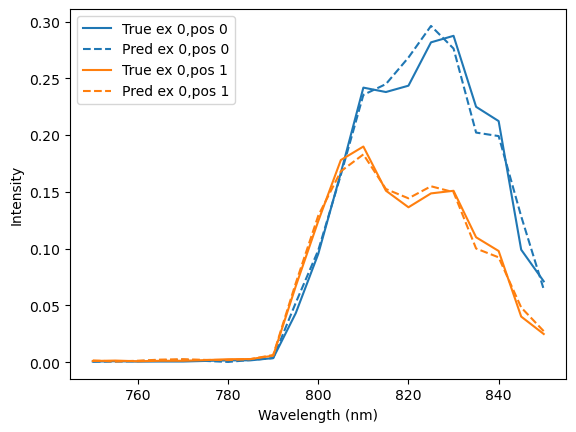

In [11]:
wls = np.linspace(750,850,21)

fig = plt.figure()
ax = fig.add_subplot(111)
j=0

coords = [coords1,coords2]

for i in range(2):
        line, = ax.plot(wls,y[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),label=   f'True ex {j},pos {i}')
        ax.plot(wls,y_pred[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred ex {j},pos {i}')


ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
plt.legend()

Text(0.5, 1.0, 'crop+denoise')

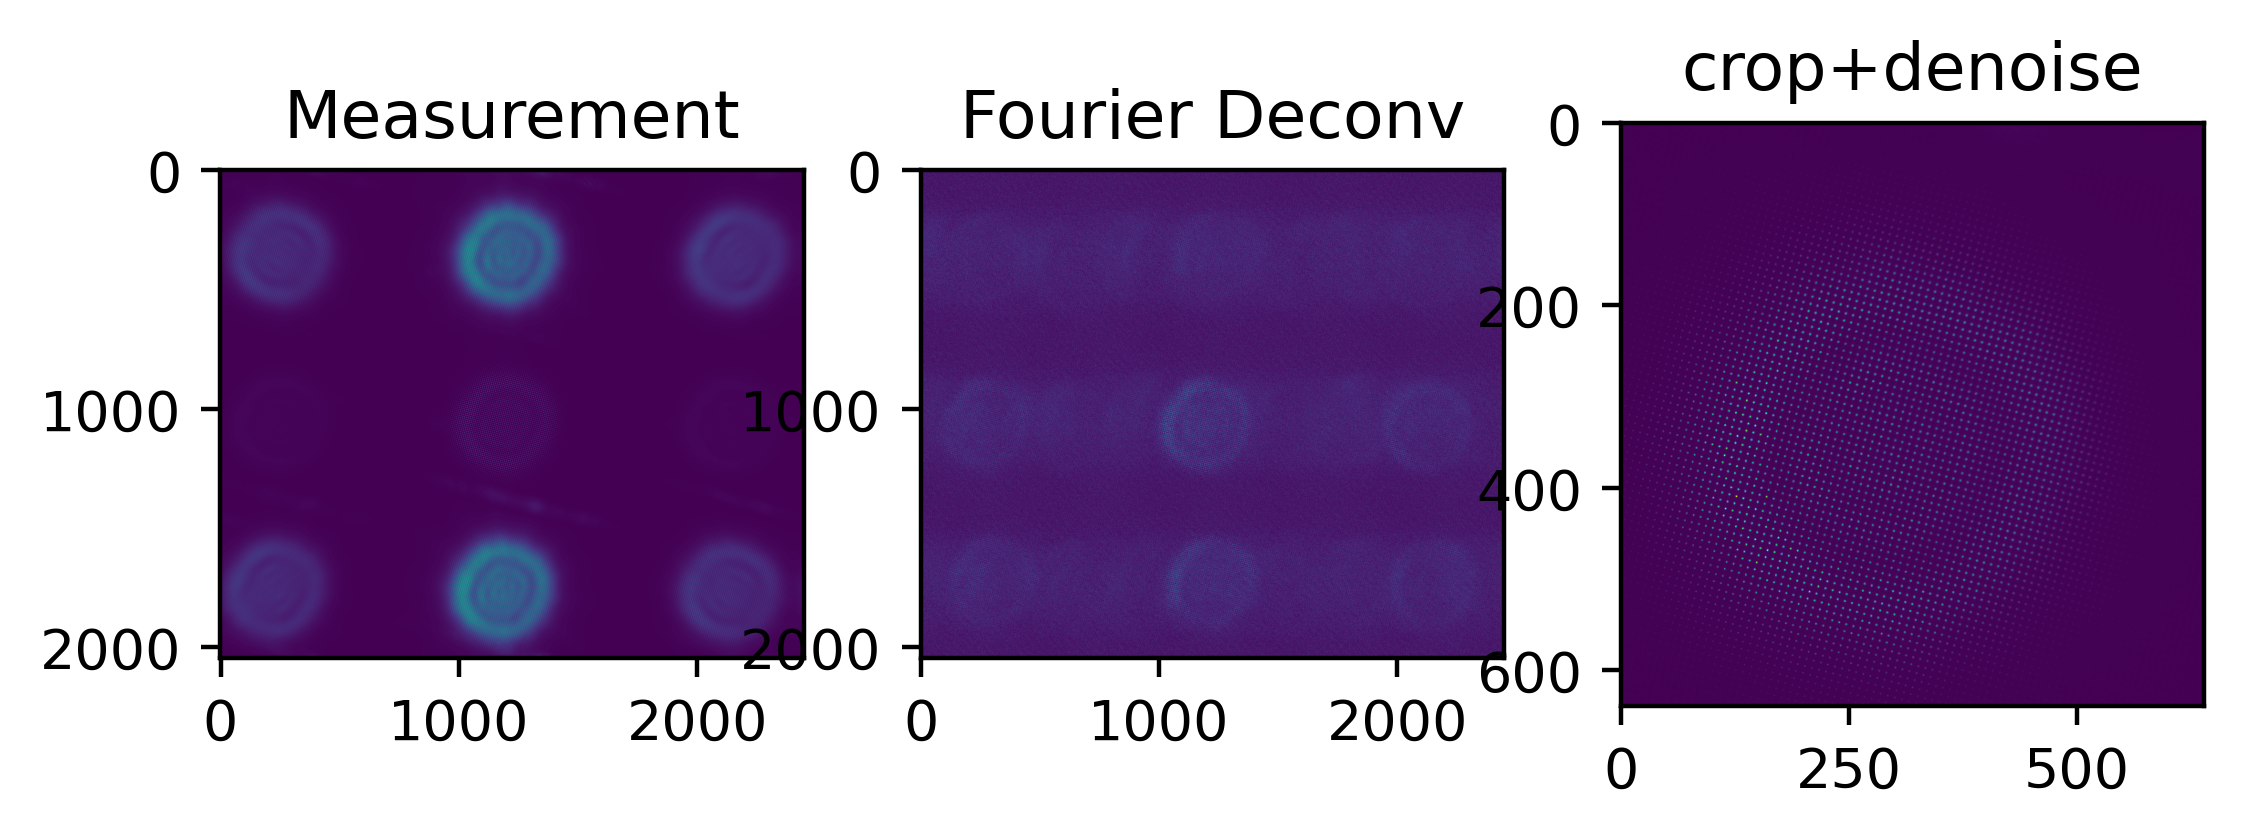

In [13]:
fig,ax = plt.subplots(1,3,dpi=400)
ax[0].imshow(x[0].cpu().detach().numpy()); ax[0].set_title('Measurement')
ax[1].imshow(model.data_term(x)[0,10].cpu().detach().numpy()); ax[1].set_title('Fourier Deconv')
ax[2].imshow(model(x)[0,10].cpu().detach().numpy()); ax[2].set_title('crop+denoise')

### Make a cube with STCs

In [15]:
x_ = torch.linspace(-1,1,500)
y_ = torch.linspace(-1,1,500)
x_,y_ = torch.meshgrid(x_,y_,indexing='ij')

pos = torch.abs(x_)#torch.sqrt(x_**2 + y_**2) / 2**(1/2)

big_pos = torch.ones((undisp_cube.shape[2],undisp_cube.shape[3]))

big_pos[undisp_cube.shape[2]//2-250:undisp_cube.shape[2]//2+250,undisp_cube.shape[3]//2-250:undisp_cube.shape[3]//2+250] = pos

big_pos = big_pos.to('cuda')

STC = torch.einsum('pq,r->rpq', big_pos, spectras[:,600]) + torch.einsum('pq,r->rpq', 1-big_pos, spectras[:,1200])


# STC = torch.einsum('pq,r->rpq', big_pos, torch.linspace(0,0.3,21).to('cuda')) + torch.einsum('pq,r->rpq', 1-big_pos, torch.linspace(0.3,0,21).to('cuda'))

In [16]:
# y = torch.tile(undisp_cube[:,15],(1,21,1,1))  *STC.unsqueeze(0)
y = undisp_cube *STC.unsqueeze(0)

x = fwd.calc_psi_z(torch.ones_like(y),y,{'kernel':kernel})

y = model.crop(y)
y_pred = model(x)

loss = torch.nn.MSELoss()
print('MSE: ',loss(y_pred,y).item())

MSE:  2.5016397557919845e-06


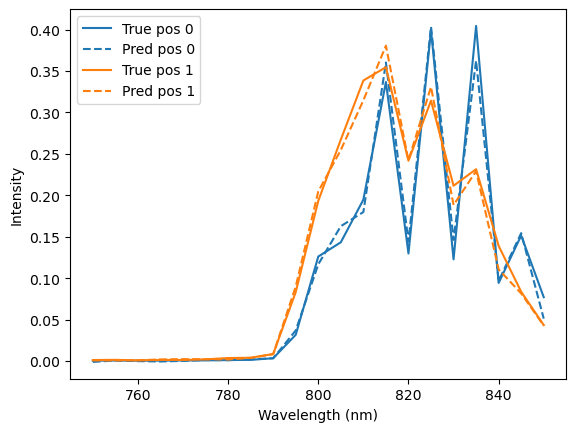

In [17]:
wls = np.linspace(750,850,21)

fig = plt.figure()
ax = fig.add_subplot(111)
j=0

line, = ax.plot(wls,y[j,:,coords1[0],coords1[1]].cpu().detach().numpy(),label=   f'True pos {0}')
ax.plot(wls,y_pred[j,:,coords1[0],coords1[1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred pos {0}')

line, = ax.plot(wls,y[j,:,coords2[0],coords2[1]].cpu().detach().numpy(),label=   f'True pos {1}')
ax.plot(wls,y_pred[j,:,coords2[0],coords2[1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred pos {1}')

# cropped_undisp = model.crop(torch.tile(undisp_cube[:,15],(1,21,1,1)))
# ax.plot(wls,cropped_undisp[j,:,coords2[0],coords2[1]].cpu().detach().numpy())

# cropped_STC_map = model.crop(STC.unsqueeze(0))
# ax.plot(wls,cropped_STC_map[j,:,coords1[0],coords1[1]].cpu().detach().numpy(),label='STC1')
# ax.plot(wls,cropped_STC_map[j,:,coords2[0],coords2[1]].cpu().detach().numpy(),label='STC2')



ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
plt.legend()

In [20]:
from forward.helper import create_spatiotemporal_intensity

/home/s/Sunny.Howard/SCI/models/helper.py:175: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if type is 'spectra':
/home/s/Sunny.Howard/SCI/models/helper.py:178: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif type is 'seperable': #not implemented yet
/home/s/Sunny.Howard/SCI/models/helper.py:182: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif type is 'spatiotemporal':


In [40]:
map = create_spatiotemporal_intensity(2,size=(21,500,500))

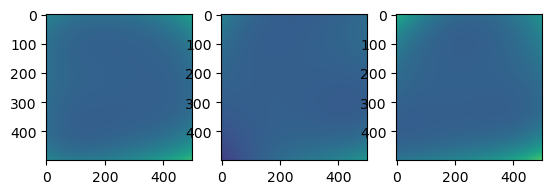

In [50]:
i= 1

vmax,vmin = map[i].max(),map[i].min()
fig,ax = plt.subplots(1,3)
ax[0].imshow(map[i,1],vmax=vmax,vmin=vmin)
ax[1].imshow(map[i,10],vmax=vmax,vmin=vmin)
ax[2].imshow(map[i,20],vmax=vmax,vmin=vmin)

